# Universidad Torcuato DiTella

# Financial Analytics

## TP Final

## Docente

Prof. Pablo Roccatagliata    --  proccatagliata@gmail.com 

## Autores
- Daniela Bessone            -- dsbessone@gmail.com          -- MiM
- Dan Frydman                -- frydmandan@gmail.com         -- MiM
- Rodrigo Corvalan Slaguero  -- rodrigocorvalan93@gmail.com  -- MFin
- Agustin Alba Chicar        -- ag.albachicar@gmail.com      -- MiM

## Repositorio

https://github.com/agalbachicar/fa_momentum

## Contenido

- [Analisis exploratorio del dataset](http://localhost:8888/notebooks/src/momentum.ipynb#1.--Realizar-un-an%C3%A1lisis-exploratorio-del-dataset.)
- [Ingenieria de features](http://localhost:8888/notebooks/src/momentum.ipynb#2.--Ingenieria-de-features)
  - [¿Encuentra valores de los features que parecen errores en los datos?](http://localhost:8888/notebooks/src/momentum.ipynb#2.1---%C2%BFNecesita-corregir-valores-faltantes?)
  - [¿Qué preprocesamiento necesitan las variables para los algoritmos de ensamble que va a utilizar?
](http://localhost:8888/notebooks/src/momentum.ipynb#2.2---%C2%BFQu%C3%A9-preprocesamiento-necesitan-las-variables-para-los-algoritmos-de-ensamble-que-va-a-utilizar?)
- [Metalabelling](http://localhost:8888/notebooks/src/momentum.ipynb#3.--Metalabelling)
  - [Momentum con medias de 50 y 200 dias](http://localhost:8888/notebooks/src/momentum.ipynb#3.1--Momentum-con-medias-de-50-y-200-dias)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [2]:
# Constantes utiles.
DATA_FILE_PATH='mtum.csv'

In [3]:
def plot_mtum(df):
    '''
    Crea una figura con dos graficos en columna.
    El grafico de arriba imprime la evolucion del precio de cierre, maximo y minimo de forma diaria.
    El grafico de abajo imprime la evolucion del volumen operado en el dia.
    
    @param df Es el data frame de pandas de donde se extraen los valores.
              Espera que tenga cuatro series completas: 'Close','High', 'Low' y 'Date'.
       
    '''
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
    
    df.plot(kind='line',y='Close', x='Date', color='blue', ax=axes[0])
    df.plot(kind='line',y='High', x='Date', color='green', ax=axes[0])
    df.plot(kind='line',y='Low', x='Date', color='red', ax=axes[0])
    df.plot(kind='line',y='Open', x='Date', color='orange', ax=axes[0])
    plt.title('MTUM prices')

    df.plot(kind='line',y='Volume', x='Date', color='blue', ax=axes[1])
    plt.title('MTUM volume')

    plt.show()


### 1.- Realizar un análisis exploratorio del dataset. 


In [4]:
# Cargamos el data frame. La información puede conseguirse en:
# https://finance.yahoo.com/quote/MTUM/history?p=MTUM
mtum_df = pd.read_csv(DATA_FILE_PATH)
mtum_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-04-18,50.919998,50.919998,50.919998,50.919998,46.707516,400
1,2013-04-19,50.919998,50.919998,50.919998,50.919998,46.707516,0
2,2013-04-22,50.919998,50.919998,50.919998,50.919998,46.707516,0
3,2013-04-23,52.220001,52.220001,52.220001,52.220001,47.899956,600
4,2013-04-24,51.700001,51.700001,51.560001,51.560001,47.294567,1100


In [5]:
mtum_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1696,2020-01-13,127.809998,128.750000,127.809998,128.750000,128.750000,483400
1697,2020-01-14,128.750000,128.759995,128.259995,128.500000,128.500000,658000
1698,2020-01-15,128.619995,129.869995,128.580002,129.589996,129.589996,648200
1699,2020-01-16,130.080002,130.649994,129.899994,130.619995,130.619995,480900
1700,2020-01-17,130.860001,131.429993,130.699997,131.380005,131.380005,641600


In [6]:
# Evaluamos los tipos de dato presentes en el dataset.
mtum_df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
# Analizo si hay duplicados
duplicate_rows_df = mtum_df[mtum_df.duplicated()]
nrows, _ = duplicate_rows_df.shape
print('El dataframe posee {} duplicados.'.format(nrows))

El dataframe posee 0 duplicados.


In [8]:
# Analisis de valores nulos.
print(mtum_df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
# Descripcion por defecto del dataset provista por pandas.
mtum_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1.701000e+03
mean,84.316349,84.700094,83.843686,84.297155,81.107621,4.605891e+05
std,22.099439,22.221504,21.946565,22.094723,23.162624,6.649536e+05
min,50.070000,50.119999,49.709999,50.119999,45.973698,0.000000e+00
25%,67.800003,68.309998,67.300003,67.790001,63.558945,3.290000e+04
50%,76.260002,76.480003,75.949997,76.220001,72.951920,2.092000e+05
75%,107.150002,108.029999,106.209999,107.239998,105.039154,6.197000e+05
max,130.860001,131.429993,130.699997,131.380005,131.380005,6.123600e+06


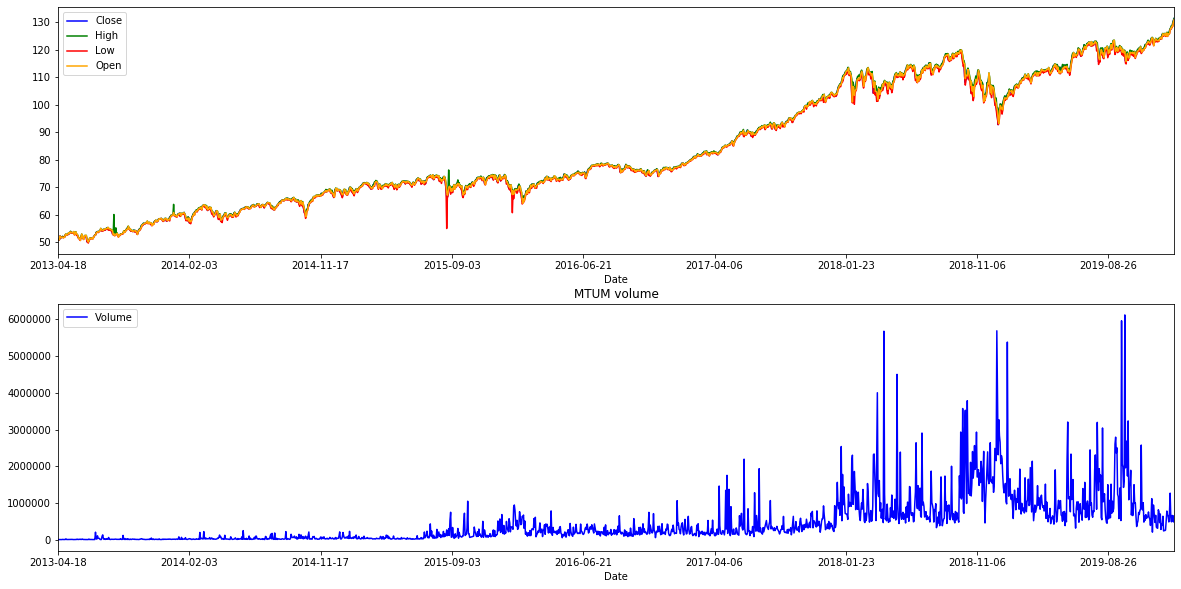

In [10]:
# Ploteamos el precio de cierre del ETF a lo largo de todo el tiempo.
plot_mtum(mtum_df)

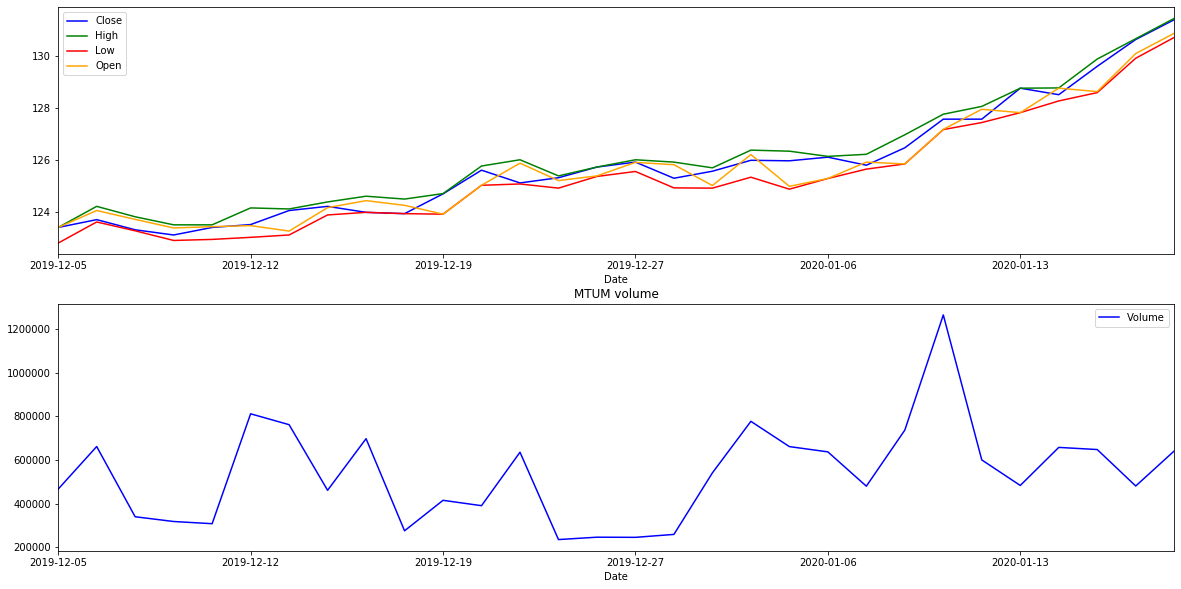

In [11]:
# Realizamos lo mismo pero para el ultimo mes.
plot_mtum(mtum_df.tail(30))

**Conclusiones**

El dataset mtum es un dataset de serie temporal diaria que contiene los precios de apertura, cierre, maximo y minimo además del volumen operado de iShares Edge MSCI USA Momentum Factor ETF (ver https://www.blackrock.com/cl/productos/251614/ishares-msci-usa-momentum-factor-etf).

El dataset no posee NA / missing data y contine aproximadamente 1700 registros, que son el resultado del registro diario desde el 18 de abril de 2013 al 13 de enero de 2020 (con la excepcion de los dias en que el ETF no opero - feriados, fines de semana, etc.).

### 2.- Ingenieria de features

#### 2.1 - ¿Necesita corregir valores faltantes?

In [12]:
# Detalle de las fechas faltantes
dates_df = mtum_df[['Date']].copy()
dates_df.Date = pd.to_datetime(dates_df['Date'], infer_datetime_format=True)
dates_df['DayOfWeek'] = dates_df.Date.dt.dayofweek
# Evaluamos si hay sabados y domingos
dates_df.loc[dates_df['DayOfWeek'].isin([5, 6])].shape

(0, 2)

In [13]:
# Buscamos el 4 de julio (feriados en USA). Para ejemplificar, el 4/7/2019 fue jueves.
dates_df.loc[dates_df['Date'] == datetime.date(year=2019, month=7, day=4)].shape

/home/agustin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  


(0, 2)

**Conclusion**

Los dias que estan, estan porque son los que el ETF opero. No se requiere corregir errores por valores faltantes.

#### 2.2 - ¿Qué preprocesamiento necesitan las variables para los algoritmos de ensamble que va a utilizar? 

Referencias:
- https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba
- Advances in Financial Machine Learning, seccion: 2.3
- https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Tick%2C%20Volume%2C%20Dollar%20Volume%20Bars.ipynb

Evaluamos la ocurrencia de outliers en la serie, con el fin de remover las entradas. Outliers en estos casos serán valores que no tienen razon de ser en el dataset.

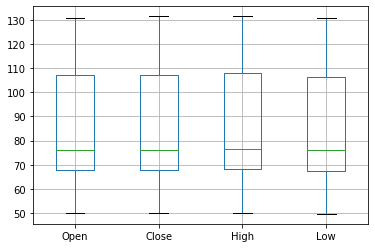

In [14]:
mtum_df.boxplot(['Open', 'Close', 'High', 'Low'])

En el grafico anterior se puede ver que no existen valores extremos imposibles.

##### Bars

**Tick bars**

No tiene sentido operar con tick bars y esta serie debido a que los tick bars cuentan el numero de operaciones realizadas. El dataset del ETF solo muestra la variacion de precios del ETF con granularidad diaria.

**Volume bars**

La generación de bars por volumen operado se adjunta a continuacion.

**Dollar bars**

La generación de bars por volumen monetizado de operación se adjunta a continuacion.

**Dollar / Volume imbalance bars**

La generación de bars por volumen o volumen monetizado imbalanceado se adjunta a continuación. A saber, los algoritmos son los mismos para ambos bars, solo cambia la serie (volumen o volumen monetizado).

In [15]:
def tick_bars(df, price_column, m):
    '''
    compute tick bars

    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    '''
    Filtra `df` por los tick_bars 
    '''
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

#-------------------------------------------------
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

#-------------------------------------------------
def create_dollar_volume_series(df, price_col, volume_col):
    return df[price_col] * df[volume_col]

def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars

    # args
        df: pd.DataFrame()
        dv_column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx].drop_duplicates()

#-------------------------------------------------
def tick_direction(prices):
    '''
    Computa un vector de ticks {1, -1} cuyo signo indica el valor
    del retorno entre dos muestras consecutivas.
    El valor inicial es el mismo que el primero computado.
    El vector de retorno tiene el mismo tamaño que @p prices.
    
    @param prices Es un vector de precios a diferenciar y obtener el signo del retorno.
    @return b_t, un vector de tick imbalance bars.
    '''
    tick_directions = prices.diff()
    tick_directions[0] = tick_directions[1]
    tick_directions = tick_directions.transform(lambda x: np.sign(x))
    return tick_directions

def signed_volume(tick_directions, volumes):
    '''
    Computa una serie de volumenes signados segun el computo de ticks.
    
    @param tick_directions La serie con el signo de del retorno.
    @param volumes La serie de volumenes para cada sample temporal de retorno.
    @return Una serie de volumenes signados, o bien el producto elemento a elemento de
            @p tick_directions con @p volumes.
    '''
    return tick_directions.multiply(volumes)

def exponential_weighted_moving_average(arr_in, window):
    '''
    @see https://stackoverflow.com/a/51392341
    
    Exponentialy weighted moving average specified by a decay ``window``
    assuming infinite history via the recursive form:

        (2) (i)  y[0] = x[0]; and
            (ii) y[t] = a*x[t] + (1-a)*y[t-1] for t>0.

    This method is less accurate that ``_ewma`` but
    much faster:

        In [1]: import numpy as np, bars
           ...: arr = np.random.random(100000)
           ...: %timeit bars._ewma(arr, 10)
           ...: %timeit bars._ewma_infinite_hist(arr, 10)
        3.74 ms ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
        262 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

    Parameters
    ----------
    arr_in : np.ndarray, float64
        A single dimenisional numpy array
    window : int64
        The decay window, or 'span'

    Returns
    -------
    np.ndarray
        The EWMA vector, same length / shape as ``arr_in``

    Examples
    --------
    >>> import pandas as pd
    >>> a = np.arange(5, dtype=float)
    >>> exp = pd.DataFrame(a).ewm(span=10, adjust=False).mean()
    >>> np.array_equal(_ewma_infinite_hist(a, 10), exp.values.ravel())
    True
    '''
    n = arr_in.shape[0]
    ewma = np.empty(n, dtype=float)
    alpha = 2 / float(window + 1)
    ewma[0] = arr_in[0]
    for i in range(1, n):
        ewma[i] = arr_in[i] * alpha + ewma[i-1] * (1 - alpha)
    return ewma

def compute_initial_e_v(signed_volumes):
    '''
    Computa el valor absoluto de la media de los volumenes signados.
    Sirve como estimacion del valor inicial de Φ_T para toda la serie de volumenes.
    '''
    return abs(signed_volumes.mean())

def compute_tick_imbalance(signed_volumes, e_t_0, abs_e_v_0):
    '''
    @param signed_volumes Serie de volumenes signados.
    @param e_t_0 El valor inicial de la $E(T)$
    @param abs_e_v_0 El valor absoluto del valor medio (hint) de $Φ_T$.
    @return Una tupla {Ts, abs_thetas, thresholds, i_s} donde:
        Ts: es un vector con los valores de $T$ que se tomaron como largo de ventana de EWMA.
        abs_thetas: es un vector que indica los valores de Φ_T para cada valor de volumen.
        thresholds: es un vector que indica el valor the umbrales que se como para cada valor de volumen.
        i_s: es un vector con los valores de los indices que referencia al vector de volumen con un cambio de tick.
    '''
    Ts, i_s = [], []
    
    # Valores de la iteracion
    # i_prev: valor de indice previo donde se fijo $T$.
    # e_t: $E(T)$ iteracion a iteracion.
    # abs_e_v: $|Φ_T|$ iteracion a iteracion.
    i_prev, e_t, abs_e_v  = 0, e_t_0, abs_e_v_0
    
    n = signed_volumes.shape[0]
    signed_volumes_val = signed_volumes.values.astype(np.float64)
    abs_thetas, thresholds = np.zeros(n), np.zeros(n)
    abs_thetas[0], cur_theta = np.abs(signed_volumes_val[0]), signed_volumes_val[0]
    for i in range(1, n):
        cur_theta += signed_volumes_val[i]
        abs_theta = np.abs(cur_theta)
        abs_thetas[i] = abs_theta
        
        threshold = e_t * abs_e_v
        thresholds[i] = threshold
        
        if abs_theta >= threshold:
            cur_theta = 0
            Ts.append(np.float64(i - i_prev))
            i_s.append(i)
            i_prev = i
            e_t = exponential_weighted_moving_average(np.array(Ts), window=np.int64(len(Ts)))[-1]
            abs_e_v = np.abs(exponential_weighted_moving_average(signed_volumes_val[:i], window=np.int64(e_t_0 * 3))[-1] ) # window of 3 bars
    return Ts, abs_thetas, thresholds, i_s

/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


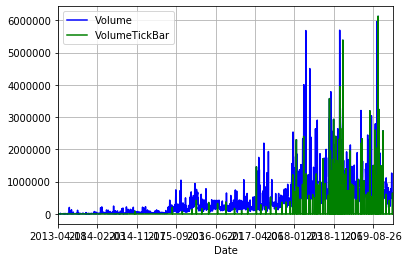

In [16]:
# Genero una serie con los valores del bar de volumenes. El valor de seleccion
# de volumen de corte es arbitrario, simplemente para ejemplificar la de generacion y visualizacion.
t = 20 * mtum_df.Volume.mean() # Valor arbitrario
mtum_df['VolumeTickBar'] = 0

idx = volume_bars(mtum_df, 'Volume', t)
mtum_df.VolumeTickBar.iloc[idx] = mtum_df.Volume.iloc[idx]

ax = mtum_df.plot(kind='line', y='Volume', x='Date', color='blue')
mtum_df.plot(kind='line', y='VolumeTickBar', x='Date', color='green', ax=ax)
plt.grid()
plt.show()

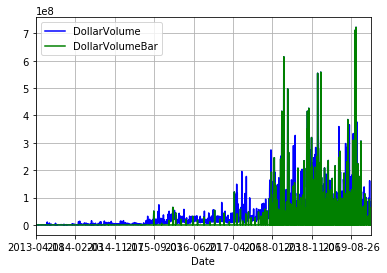

In [17]:
mtum_df['DollarVolume'] = create_dollar_volume_series(mtum_df, 'Close', 'Volume')

# Genero una serie con los valores del bar de volumenes dolarizados. El valor de seleccion
# de corte es arbitrario, simplemente para ejemplificar la de generacion y visualizacion.
t = 10 * mtum_df.DollarVolume.mean() # Valor arbitrario
mtum_df['DollarVolumeBar'] = 0

idx = dollar_bars(mtum_df, 'DollarVolume', t)
mtum_df.DollarVolumeBar.iloc[idx] = mtum_df.DollarVolume.iloc[idx]

ax = mtum_df.plot(kind='line', y='DollarVolume', x='Date', color='blue')
mtum_df.plot(kind='line', y='DollarVolumeBar', x='Date', color='green', ax=ax)
plt.grid()
plt.show()

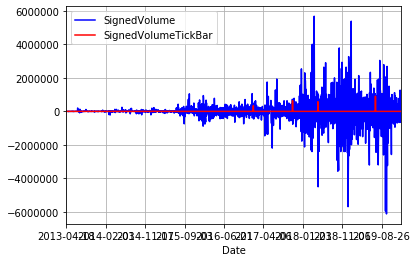

In [18]:
# Genero una nueva serie, el volumen signado por variacion de precio.
mtum_df['SignedVolume'] = signed_volume(tick_direction(mtum_df.Close), mtum_df.Volume)
mtum_df['SignedVolumeTickBar'] = 0

e_t_0 = 200 # Arbitrario
Ts, abs_thetas, thresholds, i_s = compute_tick_imbalance(mtum_df.SignedVolume, e_t_0, compute_initial_e_v(mtum_df.SignedVolume))
mtum_df.SignedVolumeTickBar.iloc[i_s] = mtum_df.SignedVolume.iloc[i_s]

# Mostramos los ticks imbalance volume dollar bars.
ax = mtum_df.plot(kind='line',y='SignedVolume', x='Date', color='blue')
ax = mtum_df.plot(kind='line',y='SignedVolumeTickBar', x='Date', color='red', ax = ax)
plt.grid()
plt.show()

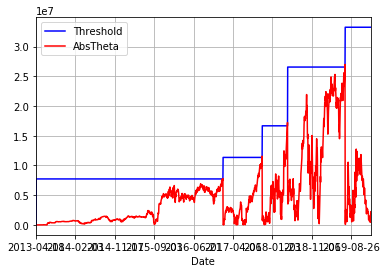

In [19]:
# Genero un data frame para plotear y mostrar la evolucion del threshold y la evolucion del volumen agregado.
# Cada cambio de threshold se relaciona con un tick en VIB.
tib_df = mtum_df[['Date']].copy()
tib_df['Threshold'] = thresholds
tib_df['AbsTheta'] = abs_thetas

ax = tib_df.plot(kind='line', y='Threshold', x='Date', color='blue')
tib_df.plot(kind='line',y='AbsTheta', x='Date', color='red', ax=ax)
plt.grid()
plt.show()

### 3.- Metalabelling

#### 3.1- Momentum con medias de 50 y 200 dias

Existen muchas formas de implementar momentum, una de estas es con los cruces entre las medias de 50 y 200 días como en el ejercicio
[3.4 del López de Prado](https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Labeling%20and%20MetaLabeling%20for%20Supervised%20Classification.ipynb). 

In [20]:
def compute_ewma(prices, window_size):
    '''
    Computes the EWMA of a price series with a certain window size.
    
    @param prices A pandas series.
    @param window_size EWMA window size.
    @return The EWMA with `window_size` window size of `prices`.
    '''
    return prices.ewm(window_size).mean()

def get_up_cross(fast_ewma, slow_ewma):
    '''
    Computes the fast EWMA serie cross over the slow EWMA serie.
    
    @param fast_ewma A fast EWMA pandas series.
    @param slow_ewma A slow EWMA pandas series.
    @return A filtered version of `fast_ewma` that indicates when the buy trend starts.
    '''
    crit1 = fast_ewma.shift(1) < slow_ewma.shift(1)
    crit2 = fast_ewma > slow_ewma
    return fast_ewma[(crit1) & (crit2)]

def get_down_cross(fast_ewma, slow_ewma):
    '''
    Computes the slow EWMA serie cross over the fast EWMA serie.
    
    @param fast_ewma A fast EWMA pandas series.
    @param slow_ewma A slow EWMA pandas series.
    @return A filtered version of `fast_ewma` that indicates when the sell trend starts.
    '''
    crit1 = fast_ewma.shift(1) > slow_ewma.shift(1)
    crit2 = fast_ewma < slow_ewma
    return fast_ewma[(crit1) & (crit2)]

def create_bet_signal_fast_slow_ewma(df, price_column, fast_window_size, slow_window_size):
    '''
    Computes the buy / sell events based on the 50-200 EWMA cross.
    
    Appends three series to `df`:
    1- FastEWMA : the fast EWMA computed with `fast_window_size`.
    2- SlowEWMA : the fast EWMA computed with `slow_window_size`.
    3- BetEWMA : an integer series with {1, 0, -1} values meaning {Buy, Do nothing, Sell}.
    
    @param df A pandas data frame to extract the price series from.
    @param price_column A string telling the name of the price series.
    @param fast_window_size The fast EWMA window size.
    @param slow_window_size The slow EWMA window size.
    @return `df` with the appended columns.
    '''
    fast_ewma = compute_ewma(df[price_column], fast_window_size)
    slow_ewma = compute_ewma(df[price_column], slow_window_size)
    buy_bet = get_up_cross(fast_ewma, slow_ewma)
    sell_bet = get_down_cross(fast_ewma, slow_ewma)
    
    df['FastEWMA'] = fast_ewma
    df['SlowEWMA'] = slow_ewma
    df['BetEWMA'] = 0
    df.BetEWMA.iloc[buy_bet.index] = 1
    df.BetEWMA.iloc[sell_bet.index] = -1
    return df

In [23]:
def plot_ewma_bet_signals(df):
    f, ax = plt.subplots(figsize=(20,10))

    df.plot(ax=ax, alpha=.5, y='Close', x='Date', color='blue')
    df.plot(ax=ax, alpha=.5, y='FastEWMA', x='Date', color='yellow')
    df.plot(ax=ax, alpha=.5, y='SlowEWMA', x='Date', color='brown')
    df.Close.loc[df.BetEWMA == 1].plot(ax=ax, ls='', marker='^', markersize=7, alpha=0.75, label='Buy', color='green')
    df.Close.loc[df.BetEWMA == -1].plot(ax=ax, ls='', marker='v', markersize=7, alpha=0.75, label='Sell', color='red')
    ax.grid()
    ax.legend()

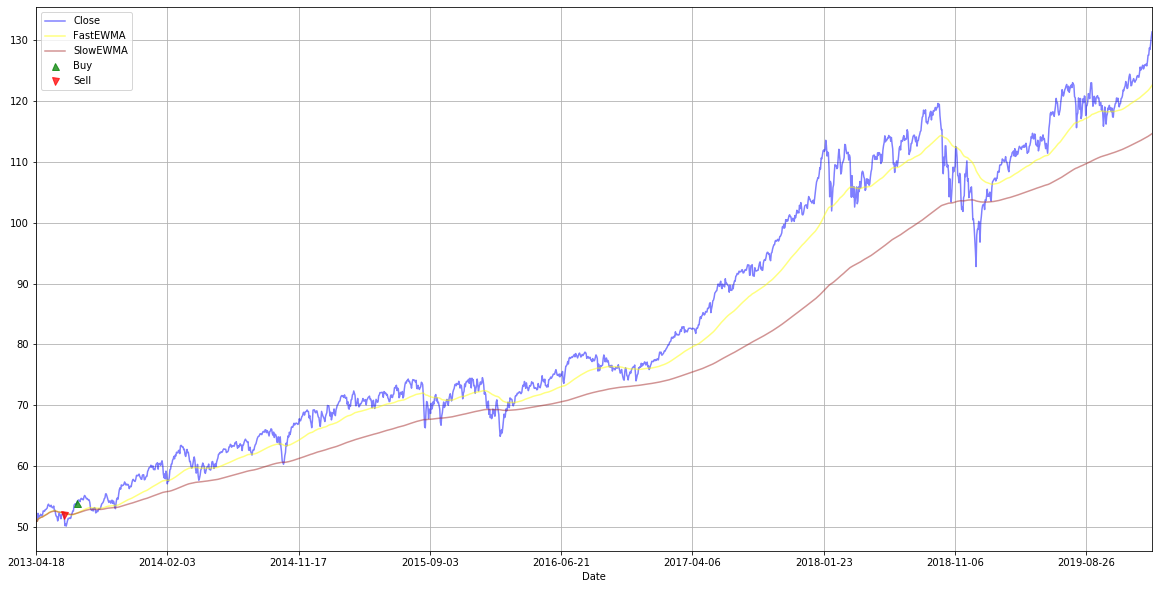

In [24]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 50, 200)
plot_ewma_bet_signals(mtum_df)

Es importante notar que solo se produjeron una señal de venta y otra de compra. Como se sabe, los valores de ventanas temporales no fueron aprendidos, por lo que a modo de ejemplificar se muestran algunas graficas de progresiones mas rapidas en ambas ventanas.

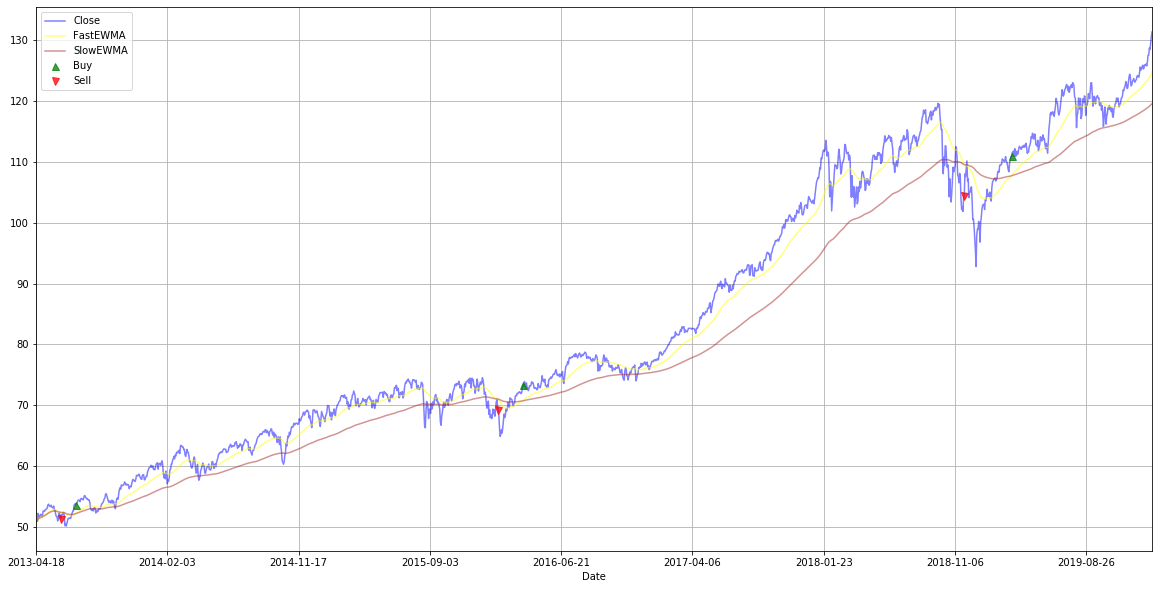

In [28]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 25, 100)
plot_ewma_bet_signals(mtum_df)

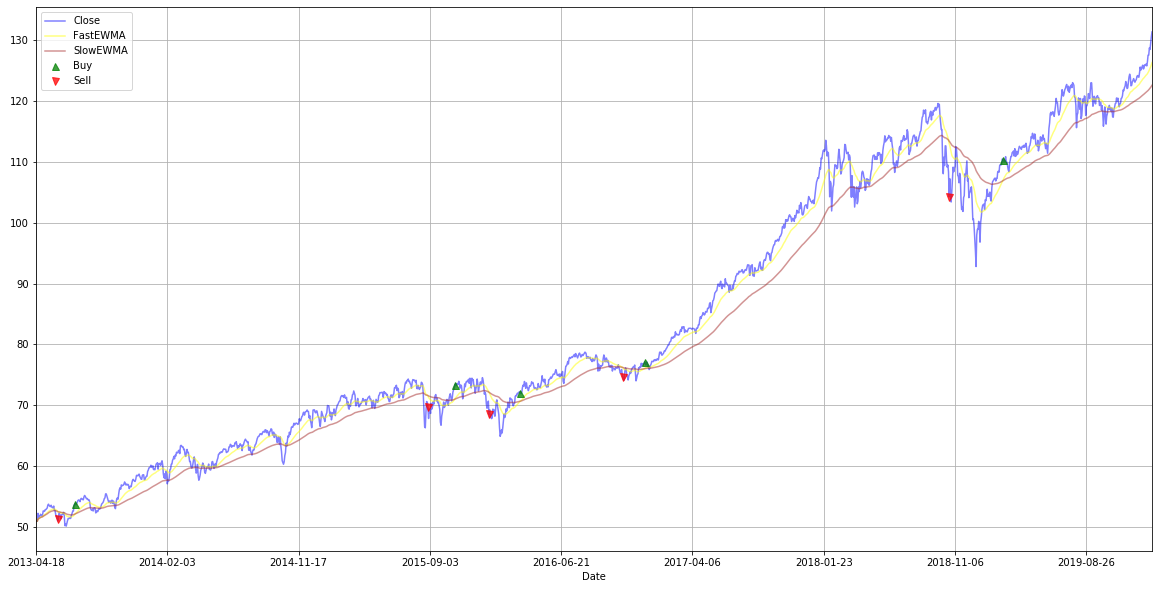

In [29]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 14, 50)
plot_ewma_bet_signals(mtum_df)

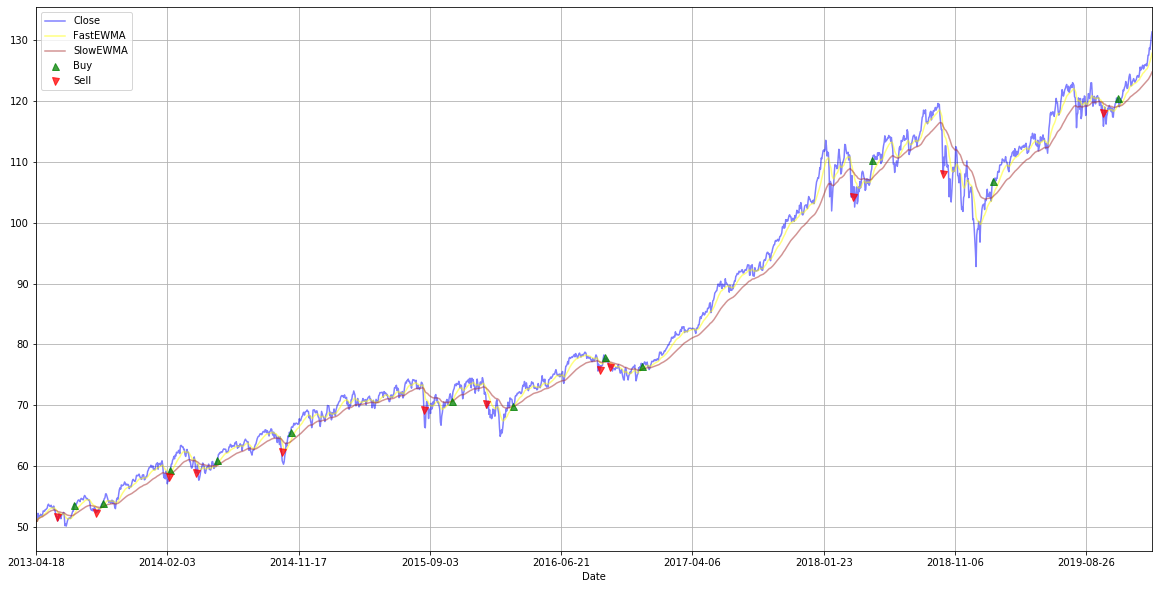

In [30]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 7, 25)
plot_ewma_bet_signals(mtum_df)